In [1]:
import time, random, os, shutil
from CosyMatrix import CosyMatrix
from CosyMagnet import CosyMagnet
from Emulator import Emulator
from NonRedundant import NonRedundant
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.interpolate import CubicSpline
from CosyIO import CosyIO
from SECAR import SECAR
from SECARMagnet import SECARMagnet
from StaticSECARMagnet import StaticSECARMagnet

In [2]:
# Get the list of all files and directories
path = "MagnetData/Magnet_1_v2"
dir_list = os.listdir(path)
scales = [ float(name) for name in dir_list ]

In [3]:
''' Load all the files in the directory '''

big_matrix = []
cosyIO = CosyIO()
for i in range(len(dir_list)):
    cosyIO.read(os.path.join(path,dir_list[i]))
    big_row = []
    for mat in cosyIO.matrices:
        for row in mat:
            big_row.append(row)
    big_matrix.append(big_row)
big_matrix = np.array(big_matrix)

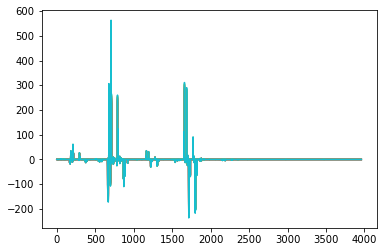

In [4]:
for i in range(10):
    plt.plot(big_matrix[i])
plt.show()

In [5]:
def error(emulated,real):
    return np.sqrt(np.sum(np.square(emulated - real))/np.sum(np.square(real)))

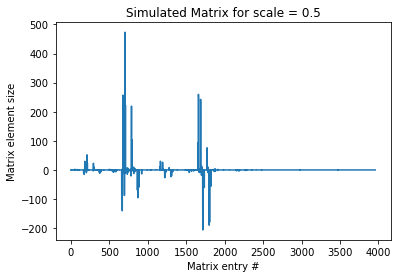

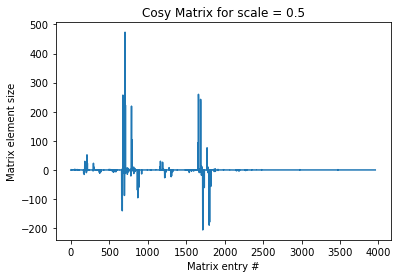

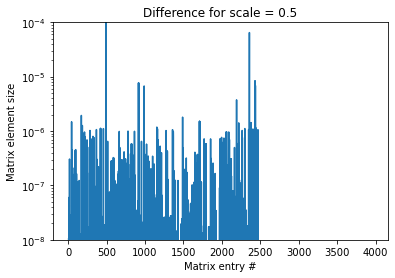

In [6]:
''' Test one emulator instance '''
from math import *

MagnetEmulator = Emulator(scales,big_matrix,15)

plt.plot(MagnetEmulator(0.5))
plt.title("Simulated Matrix for scale = 0.5")
plt.xlabel("Matrix entry #")
plt.ylabel("Matrix element size")
plt.show()
plt.plot(big_matrix[0])
plt.title("Cosy Matrix for scale = 0.5")
plt.xlabel("Matrix entry #")
plt.ylabel("Matrix element size")
plt.show()

emulated = MagnetEmulator(0.5)
real     = big_matrix[0]
relative = [ abs(real[i]-emulated[i]) / ( real[i] if real[i]!=0 else (emulated[i] if emulated[i]!=0 else 1) ) for i in range(len(real)) ]

plt.semilogy(relative)
plt.ylim(1E-8,1E-4)
plt.title("Difference for scale = 0.5")
plt.xlabel("Matrix entry #")
plt.ylabel("Matrix element size")
plt.show()

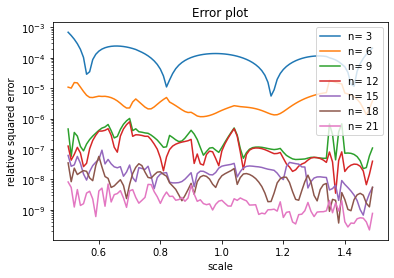

In [7]:
''' Tests several instances '''
nEmulators = 7
Emulators  = [ Emulator(scales,big_matrix,3*i+3) for i in range(nEmulators) ]
error_matrix = [ [ error(Emulators[i](scales[j]),big_matrix[j]) for j in range(len(scales)) ] for i in range(nEmulators) ]
for i in range(nEmulators):
    plt.semilogy(scales,error_matrix[i],label="n= "+str(3*i+3))
plt.xlabel("scale")
plt.ylabel("relative squared error")
plt.title("Error plot")
plt.legend()
plt.show()

In [8]:
''' Timing checkup '''
path_magnet1 = "MagnetData/Magnet_1_train"
magnet1 = CosyMagnet(path=path_magnet1,cutoff=10)

minimum = min(magnet1.axis)
maximum = max(magnet1.axis)

nevals = 10000

start = time.time()
for i in range(nevals):
    scale = minimum + random.random()*(maximum-minimum)
    magnet1(scale)
print(str(nevals),"evaluations took",time.time()-start,"seconds")

10000 evaluations took 13.823241233825684 seconds


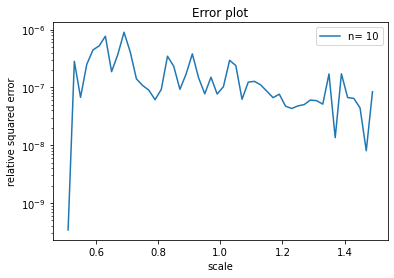

In [9]:
''' Accuarcy checkup '''
error_matrix = [ error(magnet1(magnet1.axis[i]),magnet1.matrix[i]) for i in range(len(magnet1.axis)) ] 
plt.semilogy(magnet1.axis,error_matrix,label="n= "+str(magnet1.cutoff))
plt.xlabel("scale")
plt.ylabel("relative squared error")
plt.title("Error plot")
plt.legend()
plt.show()

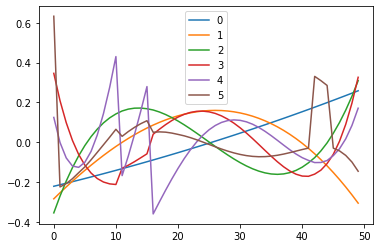

In [10]:
''' Parameter Space Eigenfunctions '''
for i in range(6):
    plt.plot(magnet1.u[:,i],label=str(i))
plt.legend()
plt.show()

In [11]:
''' Sample use of the parser '''
scale = 0.5626
magnet1.write(scale,os.path.join("Generated_Magnet_Data",str(scale)))

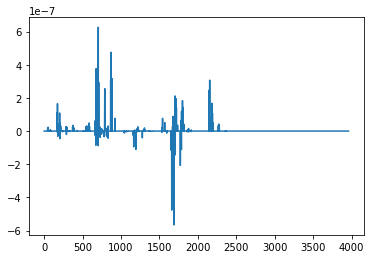

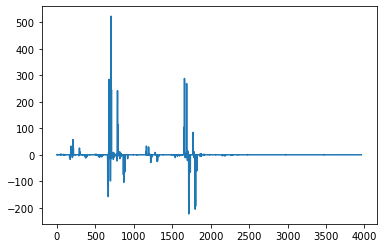

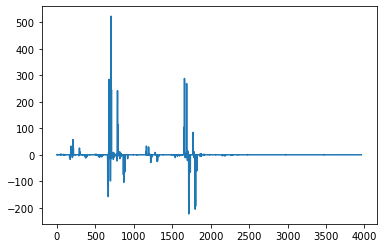

In [12]:
''' Comparison between Redundant and NonRedundant Emulators '''
emul2 = NonRedundant(scales,big_matrix,21)
emul1 = Emulator(scales,big_matrix,21)
index = 1
plt.plot(emul2(scales[i])-big_matrix[i])
plt.show()
plt.plot(big_matrix[i],label="Cosy")
plt.show()
plt.plot(emul1(scales[i]))
plt.show()

In [13]:
import math
import array
import random
import numpy as np
from scipy.stats import gaussian_kde
import pandas as pd
from scipy.special import rel_entr
import subprocess
import matplotlib.pyplot as plt
import cosyHelp as cosy
import time

In [14]:
''' Based on Main.py  '''


n = 1
magnets = np.linspace(1.0-0.5, (1.0+0.5-1/n), n)
magnets_names = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'B1', 'B2', 'S1']
#print(magnets)

#============================================ BEAM INPUT ======================================================

# Distribution at target
xh = 0 # center of x distribution in mm
yh = 0 # center of x distribution in mm
widthX = 1.5/2 # half x- beam spot in mm
widthY = 1.5/2 # half y- beam spot in mm
dE = 0.0025 # half of total energy spread in fraction 1% = 0.01
#dE = 0.00 # half of total energy spread in fraction 1% = 0.01
aX = 5 # mrad
aY = 5 # mrad

numberMC = 1000 # number of beam particles. Was 800

#=============================================================================================================
# Function that generates positions and angles at the target within the input parameters
#=============================================================================================================

def generateInitialDistribution(widthX, widthY, aX, aY):
	beam = np.zeros([numberMC, 8], dtype="float64", order="F")

	for j in range(numberMC):
		# Sampling within ellipse of possible positions
		r = widthX * np.sqrt(random.uniform(0, 1))
		theta = random.uniform(0, 1) * 2 * np.pi
		x = xh + r * np.cos(theta)
		y = yh + widthY/widthX *  r * np.sin(theta)
		beam[j][0] = x/1000 # in m
		beam[j][2] = y/1000 # in m

		# Sampling within ellipse of possible angles
		r = aX * np.sqrt(random.uniform(0, 1))
		theta = random.uniform(0, 1) * 2 * np.pi
		angleX = r * np.cos(theta)
		if aX != 0:
			angleY = aY/aX *  r * np.sin(theta)
		else:
			angleY = aY * np.sqrt(random.uniform(0, 1))
		beam[j][1] = angleX/1000 # in rad
		beam[j][3] = angleY/1000 # in rad
		beam[j][5] = dE
	return (beam)


#=============================================================================================================
# Main program
#=============================================================================================================


''' We could also try using CosyIO to mimic these calls to Cosy '''
def main():

    print('Start running')

    ''' Don't need this '''
    # Print Matrix elements for the magnets in magnet_names list and for scaling factors in magnets list.
    for i in range(len(magnets_names)):
        if magnets_names[i]== 'B1' or magnets_names[i]== 'B2':
            start_time = time.time()
            cosy.COSYSingleRun([1.0], magnets_names, 0, i)
            mv_cmd = 'mv "%s" "%s"' % ("fort.50",  'Results/' + magnets_names[i] + '_' + str(1.0))
            subprocess.call(mv_cmd, shell=True)
            print(i, "--- %s seconds ---" % (time.time() - start_time))
        else:
            for j in range(len(magnets)):
                start_time = time.time()
                cosy.COSYSingleRun(magnets, magnets_names, j, i)
                mv_cmd = 'mv "%s" "%s"' % ("fort.50",  'Results/' + magnets_names[i] + '_' + str(magnets[j]))
                subprocess.call(mv_cmd, shell=True)
                print(i, "--- %s seconds ---" % (time.time() - start_time))

    # x, ax, y, ay, dL, dE, dM, dZ
    ''' Beam init '''
    beam_in = generateInitialDistribution(widthX, widthY, aX, aY)
    ax_in = beam_in.transpose()[3]
    plt.hist(ax_in, color='blue', bins=np.linspace(-5e-2, 5e-2, 500))

    ''' Neither does this '''
    test_scale = 0.5626
    cosy.COSYSingleRun([test_scale], ['Q1'], 0, 0) # args = magnet scale values array, magnet name array, index in magent scale array, index in magnet name array
    mv_cmd = 'mv "%s" "%s"' % ("fort.50",  'test_map0.txt')
    subprocess.call(mv_cmd, shell=True)
    beam_out = cosy.transportTotal(beam_in, 'test_map0.txt') # args = input beam distribution array, transport map file name
    ax_out = beam_out.transpose()[3]
    plt.hist(ax_out, color='k', bins=np.linspace(-5e-2, 5e-2, 500), alpha=0.5)

    ''' This part '''
    beam_out = cosy.transportTotal(beam_in, '0.5626')  # args = input beam distribution array, transport map file name
    ax_out = beam_out.transpose()[3]
    plt.hist(ax_out, color='r', bins=np.linspace(-5e-2, 5e-2, 500))
    
    plt.show()

In [15]:
''' Setup the comparison '''

base = "MagnetData"
settings = { 'Q1':'0.56', 
             'Q2':'0.67', 
             'Q3':'0.74', 
             'Q4':'0.87', 
             'Q5':'1.23', 
             'S1':'1.32' }

''' Always constant magnets '''
dipoles = [ 'B1','B2' ]
dipole_curents = [None,None]
dipole_magnets   = [ StaticSECARMagnet(path=os.path.join(base,name,"1.00")) for name in dipoles] 



In [16]:
''' Dynamic Magents require several current files to build emulators '''
dynamic_magnets = [ SECARMagnet(path=os.path.join(base,name,"full"),cutoff=10) for name in settings ]
dynamic_secar = SECAR(magnets=dynamic_magnets+dipole_magnets)

In [17]:
''' Static Magents require several current files to build emulators '''
static_magnets = [ StaticSECARMagnet(path=os.path.join(base,key,"full",settings[key])) for key in settings ]
static_secar = SECAR(magnets=static_magnets+dipole_magnets)

In [18]:
''' Initialize some beams '''
rays  = generateInitialDistribution(widthX,widthY,aY,aY)

''' Use the emulated SECAR to evolve beams '''
currents = [float(name) for name in settings.values() ]

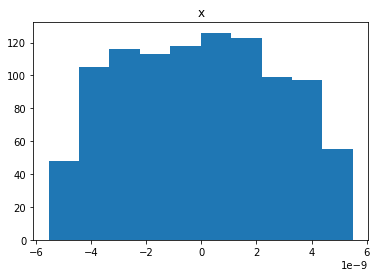

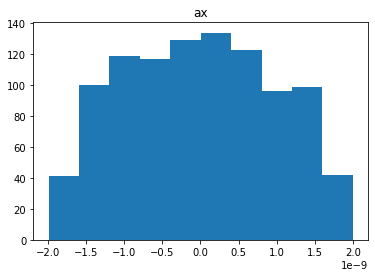

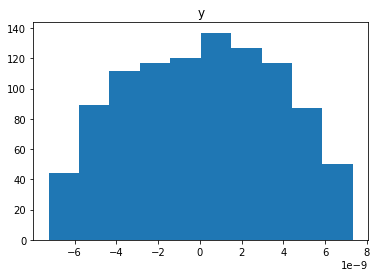

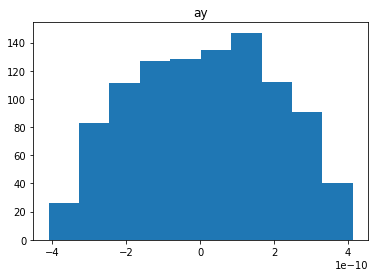

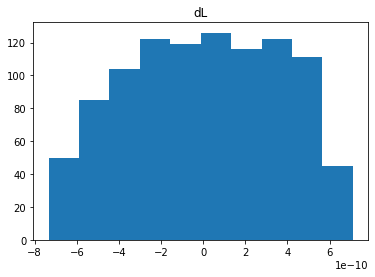

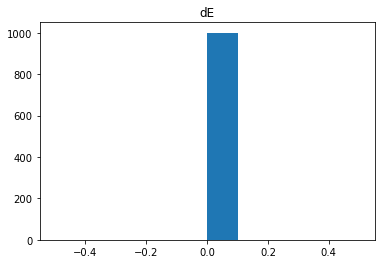

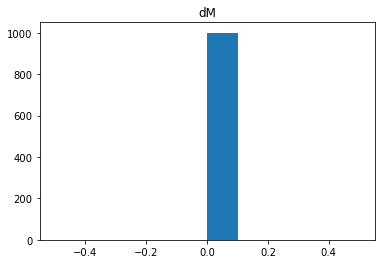

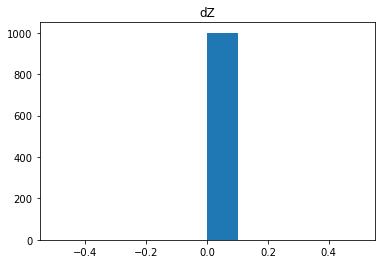

In [19]:
''' Compare the evolution using emulated and lookup magnets '''
emul_beams_out = dynamic_secar.emulate(rays=rays,currents=currents+dipole_curents)
hfid_beams_out = static_secar.emulate(rays=rays,currents=[None for i in range(static_secar.nMagnets) ])

chars = ["x", "ax", "y", "ay", "dL", "dE", "dM", "dZ"]
for i in range(len(chars)):
    plt.hist(emul_beams_out.transpose()[i]-hfid_beams_out.transpose()[i])
    plt.title(chars[i])
    plt.show()